In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras

In [2]:
pip install simpleitk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.3 MB/s eta 0:00:00


In [3]:
!unzip /content/drive/MyDrive/Brain_Tumor/MICCAI_BraTS_2019_Data_Training.zip

Archive:  /content/drive/MyDrive/Brain_Tumor/MICCAI_BraTS_2019_Data_Training.zip
   creating: MICCAI_BraTS_2019_Data_Training/HGG/
   creating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii  
   creating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_flair.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii  
  inflating: MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_

In [4]:
path = '/content/MICCAI_BraTS_2019_Data_Training/HGG'

In [5]:
import os
os.listdir(path)

['BraTS19_2013_4_1',
 'BraTS19_2013_14_1',
 'BraTS19_2013_12_1',
 'BraTS19_2013_18_1',
 'BraTS19_2013_19_1',
 'BraTS19_2013_27_1',
 'BraTS19_2013_13_1',
 'BraTS19_2013_22_1',
 'BraTS19_2013_17_1',
 'BraTS19_2013_5_1',
 'BraTS19_2013_23_1',
 'BraTS19_2013_25_1',
 'BraTS19_2013_21_1',
 'BraTS19_2013_10_1',
 'BraTS19_2013_3_1',
 'BraTS19_2013_20_1',
 'BraTS19_2013_11_1',
 'BraTS19_2013_26_1',
 'BraTS19_2013_7_1',
 'BraTS19_2013_2_1']

In [6]:
len(os.listdir(path))

20

In [7]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random as r

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')

        if label == 1:
            img[img != 0 ] = 1 # complete tumour
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # Tumour without oedema
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # Expanding Tumour
            img[img == 4 ] = 1

        img.astype('float32')

        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)

    return np.array(img_liste,np.float32) #!!!!!!!!


def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')

        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)

    return np.array(img_liste,np.float32) #!!!!!!!!

In [22]:
flair = train_array('/content/MICCAI_BraTS_2019_Data_Training/HGG/', '**/*flair.nii')
t2 = train_array('/content/MICCAI_BraTS_2019_Data_Training/HGG/','**/*t2.nii')
seg = seg_array('/content/MICCAI_BraTS_2019_Data_Training/HGG/','**/*seg.nii', 1)
seg_orj = seg_array('/content/MICCAI_BraTS_2019_Data_Training/HGG/','**/*seg.nii', 1)


In [23]:
flair.shape, seg.shape, t2.shape

((1400, 1, 240, 240), (1400, 1, 240, 240), (1400, 1, 240, 240))

In [24]:
flair.dtype, seg.dtype, t2.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [25]:
x_train = np.concatenate((flair,t2),axis=1)
x_train.dtype, x_train.shape

(dtype('float32'), (1400, 2, 240, 240))

In [29]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from keras.models import Model
from keras.layers import Input, UpSampling2D, concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def unet_model():

    inputs = Input((2, 240 , 240))

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)

    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = unet_model()

In [30]:
model.fit(x_train,seg,validation_split=0.20,batch_size=1,epochs=1,shuffle=True,verbose=1)

1120/1120 [==============================] - 125s 90ms/step - loss: 0.6069 - dice_coef: 0.3931 - val_loss: 0.4812 - val_dice_coef: 0.5188


In [34]:
seg_wide   = seg_array('/content/MICCAI_BraTS_2019_Data_Training/HGG/','**/*seg.nii', 4)
seg_unpaid = seg_array('/content/MICCAI_BraTS_2019_Data_Training/HGG/','**/*seg.nii', 3)
t1ce = train_array('/content/MICCAI_BraTS_2019_Data_Training/HGG/' ,'**/*t1ce.nii')

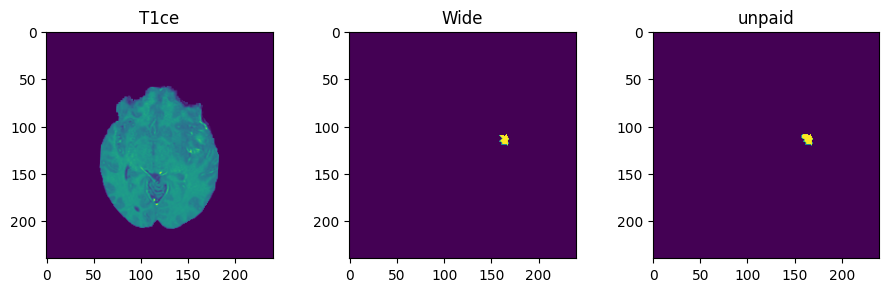

In [36]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[285,0,:,:])

plt.subplot(3,4,2)
plt.title('Wide')
plt.imshow(seg_wide[285,0,:,:])

plt.subplot(3,4,3)
plt.title('unpaid')
plt.imshow(seg_unpaid[285,0,:,:])

1/1 [==============================] - 0s 20ms/step


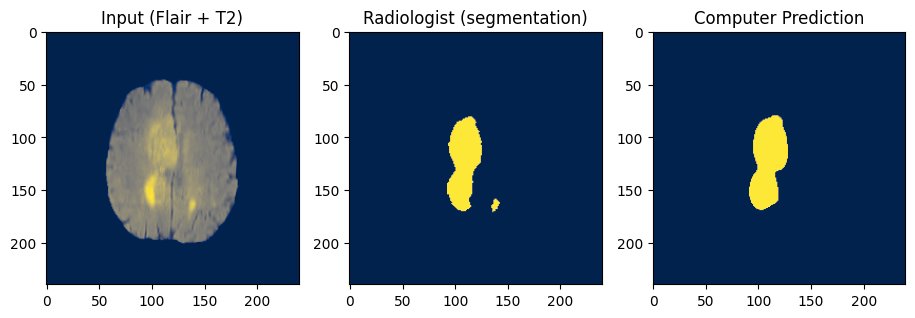

In [38]:
x    = 110
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4

example = np.expand_dims(x_train[x],axis=0)
pred = model.predict(example)


fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Input (Flair + T2)')
plt.imshow(x_train[x][0],cmap = renk[a])

plt.subplot(142)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(143)
plt.title( 'Computer Prediction' )
plt.imshow( pred[0][0],cmap = renk[a])